## 1. Installation and imports

In [1]:
!pip install google-cloud-storage
!pip install MedPy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.8/151.8 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 7.3 MB/s eta 0:00:00
  Created wheel for MedPy: filename=MedPy-0.4.0-py3-none-any.whl size=214946 sha256=e1e64abc407497b88d4a22fd098facb5048571511fae427d2e6a9c4d4a51f6f7
  Stored in directory: /root/.cache/pip/wheels/d4/32/c7/6380ab2edb8cca018d39a0f1d43250fd9791922c963117de46
Successfully built MedPy


In [2]:
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

working_dir = '/content/drive/My Drive/Capstone Project/BioCV_Su23/src'
os.chdir(working_dir)

Mounted at /content/drive


In [3]:
import importlib
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import numpy as np
import os
import seaborn as sns

# Custom modules
import utils.mri_images as mri
import utils.mri_plotter as mrp
import utils.metrics as metrics

# Note: all modules need to be reloaded inside running jupyter notebooks to recognize live updates
# Todo: delete this when the functions are finalized
importlib.reload(mri)
importlib.reload(mrp)
importlib.reload(mri)

from utils.mri_images import MriImage
from utils.mri_plotter import MRIPlotter

In [4]:
# Get segmented and auto segmented files
mri_img = MriImage()

segm_files = mri_img.list_blobs_in_folder(segm=True)
auto_segm_files = mri_img.list_blobs_in_folder(auto_segm=True)
print("No. of segmented files:", len(segm_files))
print("No. of auto-segmented files:", len(auto_segm_files))

No. of segmented files: 147
No. of auto-segmented files: 611


### Metrics

In [5]:
all_common_metrics = []
all_dice = []
all_hd95 = []
all_missclass_per_label = []
all_true_per_label = []
error_files = []

In [6]:
def calc_metric_all_segments(segments, metric_func, *args, **kwargs):
    values = Parallel(n_jobs=-1)(delayed(metric_func)(*args, **kwargs, segment=segment) for segment in segments)
    return values

In [7]:
import medpy.metric.binary as mdp
def _convert_to_binary(img, segment):
    return img == segment    

def calc_binary_metrics(pred_img, true_img, segment):
    '''
    precision: tp / tp + fp => positive predicted value
    recall: tp / tp + fn => ratio of true positives to total positives in the data
    Specificity = tn / (tn + fp) => ratio of true nagatives to total negatives in the data
    '''
    
    true_img_bin = _convert_to_binary(true_img, segment)
    pred_img_bin = _convert_to_binary(pred_img, segment)

    recall = mdp.recall(pred_img_bin, true_img_bin)
    
    metrics_dict = {
        "true_positive": np.count_nonzero(pred_img_bin & true_img_bin),
        "true_negative": np.count_nonzero(~pred_img_bin & ~true_img_bin),
        "false_positive": np.count_nonzero(pred_img_bin & ~true_img_bin),
        "false_negative": np.count_nonzero(~pred_img_bin & true_img_bin),
        "precision": mdp.precision(pred_img_bin, true_img_bin),
        "recall": recall,
        "specificity": mdp.specificity(pred_img_bin, true_img_bin),
        "sensitivity": recall,
        "true_positve_rate": recall,
        "true_negative_rate": mdp.true_negative_rate(pred_img_bin, true_img_bin)
    } 
    return metrics_dict

In [8]:
# Calculate dice score one by one for each image to avoid out-of-memory issues
subj_files = [segm_file.split("_segm")[0] for segm_file in segm_files]
for subj_file in subj_files:

  # load the segmented and auto segmented image of a file
  segm_img = mri_img.read(subj_file, segm=True)[1]
  auto_segm_img = mri_img.read(subj_file, auto_segm=True)[1]

  try:
      print(f"Calculating metrics for {subj_file}")

      # metric 1: just count incorrect labels vs true labels for each file
      misclassified_per_label = []
      true_per_label = []
      for segment in mri.SEGMENTS:
        true_count = np.sum(segm_img == segment)
        pred_count = np.sum(auto_segm_img == segment)

        count_difference = abs(true_count - pred_count)

        true_per_label.append(true_count)
        misclassified_per_label.append(count_difference)

      # metric 2: other common metrics
      common_metrics = calc_metric_all_segments(mri.SEGMENTS, calc_binary_metrics, auto_segm_img, segm_img)
      common_metrics_dict = {}
      for key in common_metrics[0]:
          common_metrics_dict[key] = [metric[key] for metric in common_metrics]
    
      # metric 3: dice coefficient
      dice_score = calc_metric_all_segments(mri.SEGMENTS, metrics.calc_dice_score, auto_segm_img, segm_img)

      # metric 4: 95% Hausdorff
      hausdorff_val =  calc_metric_all_segments(mri.SEGMENTS, metrics.calc_hausdorff_95, auto_segm_img, segm_img)

      # append only when there is no error:
      all_dice.append(dice_score)
      all_hd95.append(hausdorff_val)
      all_missclass_per_label.append(misclassified_per_label)
      all_true_per_label.append(true_per_label)
      all_common_metrics.append(common_metrics_dict)
  except Exception as ex:
      print(f"Error {subj_file}", ex)
      error_files.append(subj_file)

Calculating metrics for UPENN-GBM-00002_11
Calculating metrics for UPENN-GBM-00006_11
Calculating metrics for UPENN-GBM-00008_11
Calculating metrics for UPENN-GBM-00009_11
Calculating metrics for UPENN-GBM-00011_11
Calculating metrics for UPENN-GBM-00013_11
Calculating metrics for UPENN-GBM-00014_11
Calculating metrics for UPENN-GBM-00016_11
Calculating metrics for UPENN-GBM-00017_11
Calculating metrics for UPENN-GBM-00018_11
Calculating metrics for UPENN-GBM-00020_11
Calculating metrics for UPENN-GBM-00021_11
Calculating metrics for UPENN-GBM-00026_11
Calculating metrics for UPENN-GBM-00029_11
Calculating metrics for UPENN-GBM-00030_11
Calculating metrics for UPENN-GBM-00031_11
Calculating metrics for UPENN-GBM-00033_11
Calculating metrics for UPENN-GBM-00035_11
Calculating metrics for UPENN-GBM-00040_11
Calculating metrics for UPENN-GBM-00041_11
Calculating metrics for UPENN-GBM-00043_11
Calculating metrics for UPENN-GBM-00054_11
Calculating metrics for UPENN-GBM-00059_11
Calculating

### COUNT DIFFERENCE/ TRUE COUNT

## RESULTS

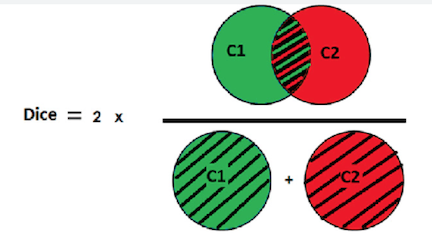

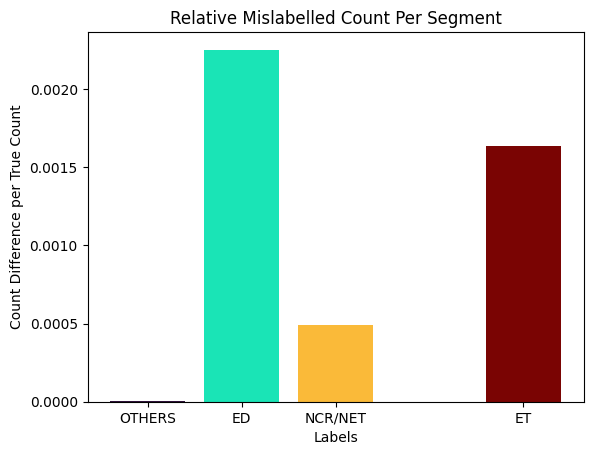

In [9]:
cmap = plt.get_cmap('turbo')
colors = cmap(np.linspace(0, 1, len(mri.SEGMENTS)))

total_misclassifed = np.array(misclassified_per_label).sum(axis = 0)
true_count = np.array(all_true_per_label).sum(axis = 0)
plt.bar(mri.SEGMENTS, total_misclassifed/true_count, color=colors)
plt.xlabel('Labels')
plt.ylabel('Count Difference per True Count')
plt.title('Relative Mislabelled Count Per Segment')
plt.xticks(mri.SEGMENTS, mri.SEGMENT_NAMES)
plt.show()

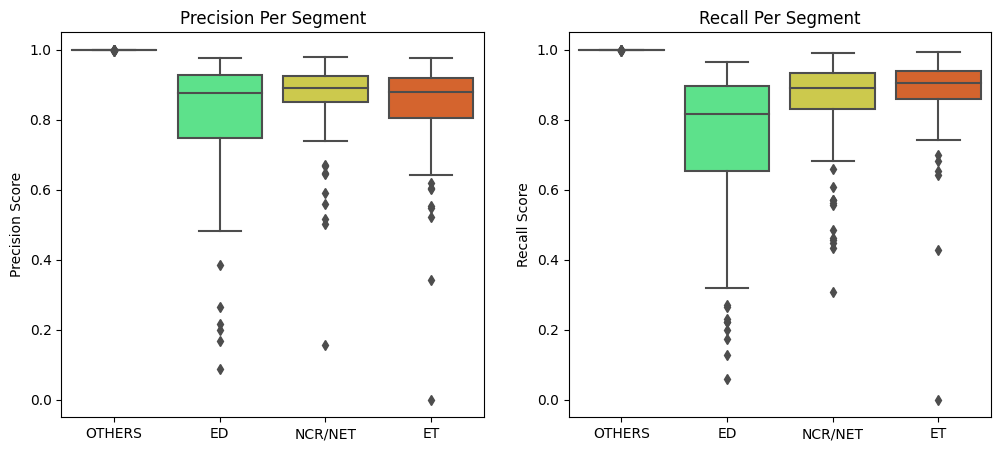

In [10]:
all_precision_np = np.array([metric['precision'] for metric in all_common_metrics])
all_recall_np = np.array([metric['recall'] for metric in all_common_metrics])

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

all_dice_np = np.array(all_dice)
sns.boxplot(data=all_precision_np,  palette="turbo", ax=axs[0])
sns.boxplot(data=all_recall_np,  palette="turbo", ax=axs[1])

axs[0].set_xticks(range(len(mri.SEGMENTS)), mri.SEGMENT_NAMES)
axs[0].set_ylabel("Precision Score")
axs[0].set_title("Precision Per Segment")
axs[1].set_xticks(range(len(mri.SEGMENTS)), mri.SEGMENT_NAMES)
axs[1].set_ylabel("Recall Score")
axs[1].set_title("Recall Per Segment")

plt.show()


### DICE SCORE PER SEGMENT

ED has the lowest (LABEL 1)

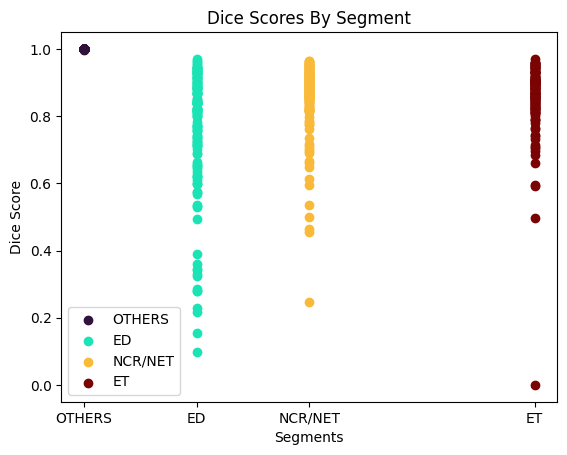

In [11]:
# Plot the dice scores as a scatter plot
cmap = plt.get_cmap('turbo')
colors = cmap(np.linspace(0, 1, len(mri.SEGMENTS)))

for idx in range(len(mri.SEGMENTS)):
  dice_scores = np.array(all_dice)[:, idx]
  label = mri.SEGMENTS[idx]
  x_val = [label] * len(dice_scores)

  plt.scatter(x_val, dice_scores, label=f"{mri.SEGMENT_NAMES[idx]}", color=colors[idx])
  plt.xlabel('Segments')
  plt.ylabel('Dice Score')
  plt.title('Dice Scores By Segment')
  plt.legend()

plt.xticks(mri.SEGMENTS, mri.SEGMENT_NAMES)
plt.show()

### DICE SCORE FOR EACH FILE

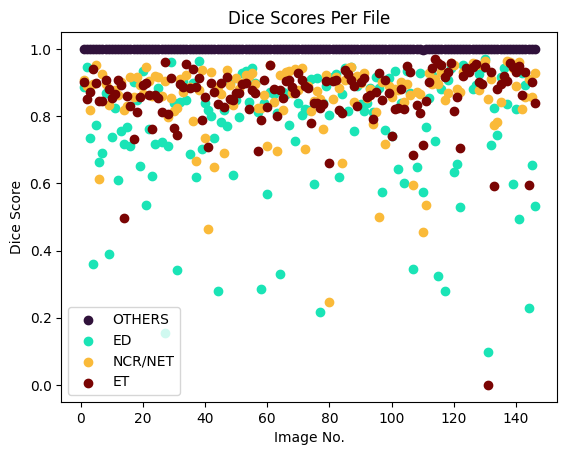

In [12]:
cmap = plt.get_cmap('turbo')
colors = cmap(np.linspace(0, 1, len(mri.SEGMENTS)))

scores_len = len(all_dice)

for segm_idx in range(len(mri.SEGMENTS)):
  dice_scores = np.array(all_dice)[:, segm_idx]
  plt.scatter(np.arange(1, scores_len+1), dice_scores, color=colors[segm_idx], label=f"{mri.SEGMENT_NAMES[segm_idx]}")

plt.xlabel('Image No.')
plt.ylabel('Dice Score')
plt.title('Dice Scores Per File')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.legend()
plt.show()

### PLOT IMAGES WITH THE LOWEST DICE SCORES

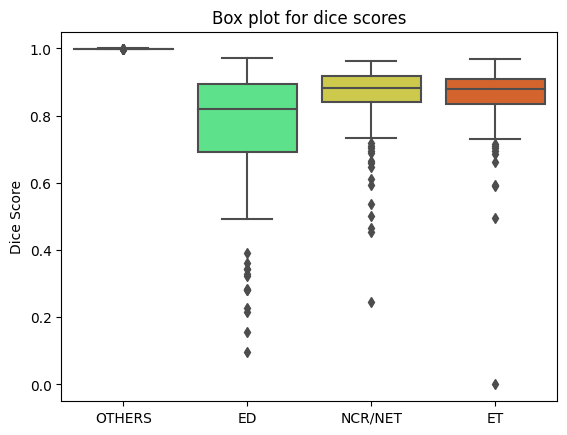

In [13]:
### Statistics
all_dice_np = np.array(all_dice)
sns.boxplot(data=all_dice_np,  palette="turbo")
plt.xticks(range(len(mri.SEGMENTS)), mri.SEGMENT_NAMES)
plt.ylabel("Dice Score")
plt.title("Box plot for dice scores")
plt.show()

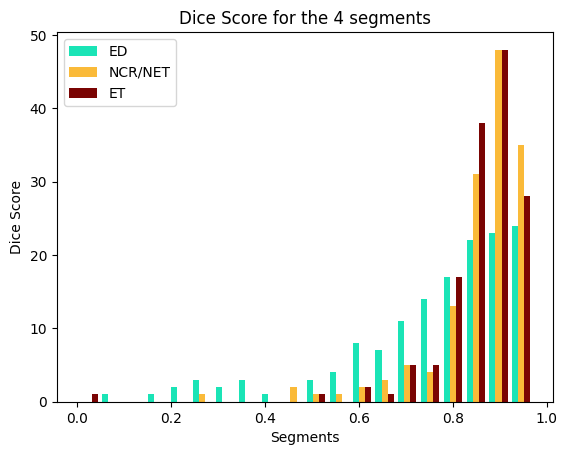

In [14]:
# Make a separate list for each segment
x2 = all_dice_np[:, 1]
x3 = all_dice_np[:, 2]
x4 = all_dice_np[:, 3]

# Assign colors for each segment and the names
cmap = plt.get_cmap('turbo')
colors = cmap(np.linspace(0, 1, len(mri.SEGMENTS)))
names = mri.SEGMENT_NAMES
         
plt.hist([x2, x3, x4], bins = 20, color = colors[1:], label=names[1:])
plt.legend()
plt.xlabel('Segments')
plt.ylabel('Dice Score')
plt.title('Dice Score for the 4 segments')
plt.show()

In [15]:
# Get 10 images with lowest dice scores
# Flatten the array
flattened_array = all_dice_np.flatten()

# Find the indices of the top 10 smallest numbers
top_10_idx_1d = np.argpartition(flattened_array, kth=10)[:10]

# Reshape the indices back to the original 2D shape
top_10_indices = np.unravel_index(top_10_idx_1d, all_dice_np.shape)

# remove error files from subj_files
print("errors", error_files)
subj_files = list(filter(lambda x: x not in error_files, subj_files))
print(f"New length after removing problematic images: {len(subj_files)}")

subj_files_np = np.array(subj_files)
lowest_dice_images = subj_files_np[list(top_10_indices[0])]

errors ['UPENN-GBM-00201_11']
New length after removing problematic images: 146


In [16]:
def get_nonzero_extents(arr):
  if not np.any(arr != 0):
    center = np.array(arr.shape) // 2
    minima = center - 1
    maxima = center + 1
    return minima, maxima
  else:
    indices = np.where(arr != 0)
    minima = np.min(indices, axis=1)
    maxima = np.max(indices, axis=1)
    return minima, maxima

def get_bounds(true_img_bin, pred_img_bin):
  min1, max1 = get_nonzero_extents(true_img_bin)
  min2, max2 = get_nonzero_extents(pred_img_bin)
  combined_min = np.minimum(min1, min2)
  combined_max = np.maximum(max1, max2)

  adj_min = np.maximum(combined_min-10, 0)
  adj_max = np.minimum(combined_max+10, np.array(true_img_bin.shape) - 1)
  return adj_min, adj_max

def slice_image(img, adj_min, adj_max):
  return img[adj_min[0]:adj_max[0]+1, 
             adj_min[1]:adj_max[1]+1,
             :]

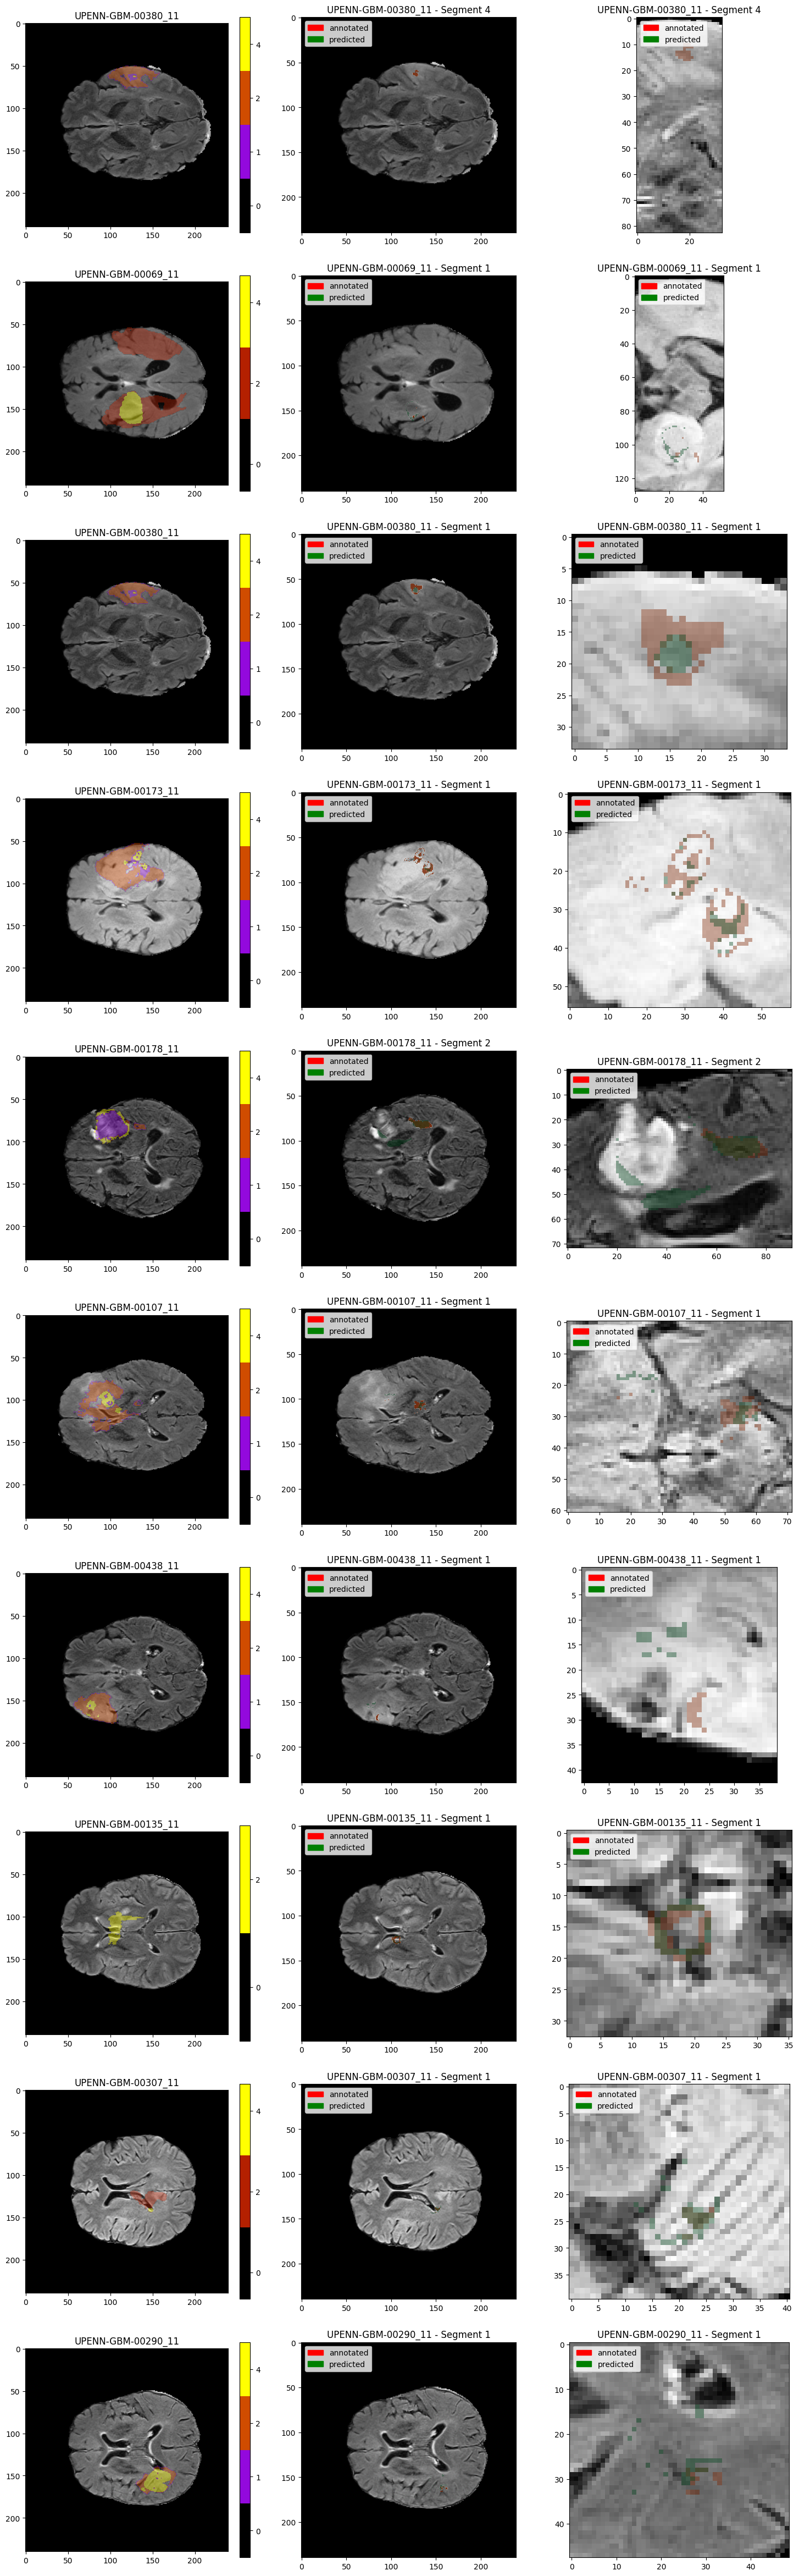

In [17]:
mri_plt = MRIPlotter()
nrows=10
ncols=3

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 6*nrows))

for idx, subj_file in enumerate(lowest_dice_images):
  # add legend
  orange = mpatches.Patch(color='red', label='annotated')
  green = mpatches.Patch(color='green', label='predicted')

  # plot base image FLAIR
  base_img = mri_img.read(subj_file=subj_file, struct_scan="FLAIR")[1]

  # plot segments with lowest dice scores
  true_img = mri_img.read(subj_file=subj_file, segm=True)[1]
  pred_img = mri_img.read(subj_file=subj_file, auto_segm=True)[1]

  # get binary images for segment in question
  segment = mri.SEGMENTS[top_10_indices[1][idx]]
  true_img_bin = (true_img == segment)
  pred_img_bin = (pred_img == segment)

  # plot all segments scan
  mri_plt.plot_struct_img(img_data=base_img, fig=fig, axs=axs, row=idx, col=0, 
                          title=f"{subj_file}", auto_cbar=False)
  mri_plt.plot_segm_img(img_data=true_img, fig=fig, axs=axs, row=idx, col=0, overlay=True)
  

  # plot full mri scan with specific segment
  mri_plt.plot_struct_img(img_data=base_img, fig=fig, axs=axs, row=idx, col=1, 
                          title=f"{subj_file} - Segment {segment}", auto_cbar=False)
  mri_plt.plot_segm_img(img_data=true_img_bin, fig=fig, axs=axs, row=idx, col=1,
                        segm_cbar=False, overlay=True, cmap='Oranges', 
                        alpha = np.where(true_img_bin == 0, 0, 0.8))
  mri_plt.plot_segm_img(img_data=pred_img_bin, fig=fig, axs=axs, row=idx, col=1, 
                        segm_cbar=False, overlay=True, cmap="Greens")
  
  axs[idx, 1].legend(handles=[orange, green], loc='upper left')

  # plot zoomed view
  adj_min, adj_max = get_bounds(true_img_bin, pred_img_bin)
  base_sliced = slice_image(base_img.copy(), adj_min, adj_max)
  true_sliced = slice_image(true_img_bin.copy(), adj_min, adj_max)
  pred_sliced = slice_image(pred_img_bin.copy(), adj_min, adj_max)
  
  mri_plt.plot_struct_img(img_data=base_sliced, fig=fig, axs=axs, row=idx, col=2, 
                          title=f"{subj_file} - Segment {segment}", auto_cbar=False)
  mri_plt.plot_segm_img(img_data=true_sliced, fig=fig, axs=axs, row=idx, col=2, 
                        segm_cbar=False, overlay=True, cmap='Oranges')
  mri_plt.plot_segm_img(img_data=pred_sliced, fig=fig, axs=axs, row=idx, col=2, 
                        segm_cbar=False, overlay=True, cmap="Greens")
  
  axs[idx, 2].legend(handles=[orange, green], loc='upper left')
plt.show()

### HAUSDORFF DISTANCES PER SEGMENT

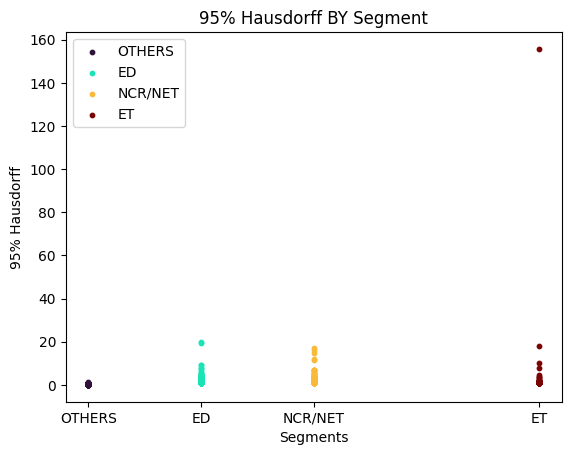

In [18]:
# Plot hausdorff scores as a scatter plot
cmap = plt.get_cmap('turbo')
colors = cmap(np.linspace(0, 1, len(mri.SEGMENTS)))

for idx in range(len(mri.SEGMENTS)):
  y_val = np.array(all_hd95)[:, idx]
  label = mri.SEGMENTS[idx]
  x_val = [label] * len(y_val)

  plt.scatter(x_val, y_val, label=f"{mri.SEGMENT_NAMES[idx]}", color=colors[idx], s=10)
  plt.xlabel('Segments')
  plt.ylabel('95% Hausdorff')
  plt.title('95% Hausdorff BY Segment')
  plt.legend()

plt.xticks(mri.SEGMENTS, mri.SEGMENT_NAMES)
plt.show()

### HAUSDORFF DISTANCES PER FILE

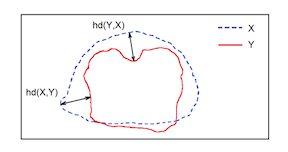

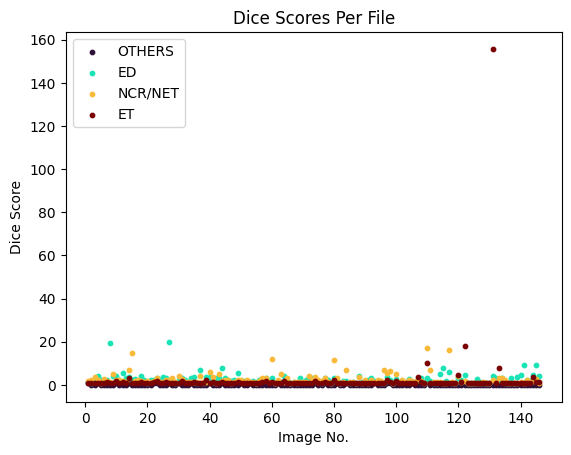

In [19]:
cmap = plt.get_cmap('turbo')
colors = cmap(np.linspace(0, 1, len(mri.SEGMENTS)))

scores_len = len(all_hd95)

for segm_idx in range(len(mri.SEGMENTS)):
  dice_scores = np.array(all_hd95)[:, segm_idx]
  plt.scatter(np.arange(1, scores_len+1), dice_scores, color=colors[segm_idx],
              label=f"{mri.SEGMENT_NAMES[segm_idx]}", s=10)

plt.xlabel('Image No.')
plt.ylabel('Dice Score')
plt.title('Dice Scores Per File')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.legend()
plt.show()

### PLOT IMAGES WITH HIGHEST HD95 SCORE

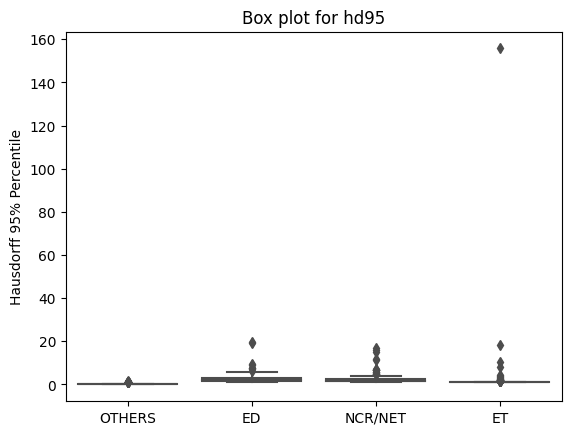

In [20]:
### Statistics
all_hd95_np = np.array(all_hd95)
sns.boxplot(data=all_hd95_np, palette="turbo")
plt.xticks(range(len(mri.SEGMENTS)), mri.SEGMENT_NAMES)
plt.ylabel("Hausdorff 95% Percentile")
plt.title("Box plot for hd95")
plt.show()

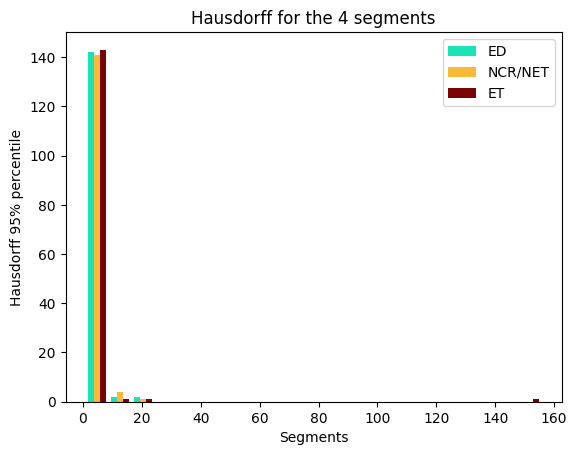

In [21]:
# Make a separate list for each segment
x2 = all_hd95_np[:, 1]
x3 = all_hd95_np[:, 2]
x4 = all_hd95_np[:, 3]

# Assign colors for each airline and the names
cmap = plt.get_cmap('turbo')
colors = cmap(np.linspace(0, 1, len(mri.SEGMENTS)))
names = mri.SEGMENT_NAMES
         
plt.hist([x2, x3, x4], bins = 20, color = colors[1:], label=names[1:])
plt.legend()
plt.xlabel('Segments')
plt.ylabel('Hausdorff 95% percentile')
plt.title('Hausdorff for the 4 segments')
plt.show()

In [22]:
# Get 10 images with lowest hausdorff distance
# Flatten the array
flattened_array = all_hd95_np.flatten()

# Find the indices of the top 10 largest numbers
top_10_idx_1d = np.argpartition(flattened_array, kth=-10)[-10:]

# Reshape the indices back to the original 2D shape
top_10_indices = np.unravel_index(top_10_idx_1d, all_hd95_np.shape)

subj_files_np = np.array(subj_files)
highest_hd95_val = subj_files_np[list(top_10_indices[0])]

In [23]:
nrows=10
ncols=3

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 6*nrows))
for idx, subj_file in enumerate(highest_hd95_val):

  # plot only the specific segment with the lowest dice coeff
  orange = mpatches.Patch(color='red', label='annotated')
  green = mpatches.Patch(color='green', label='predicted')
  
  # download FLAIR image
  base_img = mri_img.read(subj_file=subj_file, struct_scan="FLAIR")[1]

  # dowload annotated and auto segmented images
  true_img = mri_img.read(subj_file=subj_file, segm=True)[1]
  pred_img = mri_img.read(subj_file=subj_file, auto_segm=True)[1]


  # get binary images for segment in question
  segment = mri.SEGMENTS[top_10_indices[1][idx]]
  true_img_bin = (true_img == segment)
  pred_img_bin = (pred_img == segment)

  # plot full mri scan with all segments
  mri_plt.plot_struct_img(img_data=base_img, fig=fig, axs=axs, row=idx, col=0, 
                          title=f"{subj_file}", auto_cbar=False)
  mri_plt.plot_segm_img(img_data=true_img, fig=fig, axs=axs, row=idx, col=0, overlay=True)
  
  
  # plot full mri scan
  mri_plt.plot_struct_img(img_data=base_img, fig=fig, axs=axs, row=idx, col=1, 
                          title=f"{subj_file} - Segment {segment}", auto_cbar=False)
  mri_plt.plot_segm_img(img_data=true_img_bin, fig=fig, axs=axs, row=idx, col=1, 
                        segm_cbar=False, overlay=True, cmap='Oranges')
  mri_plt.plot_segm_img(img_data=pred_img_bin, fig=fig, axs=axs, row=idx, col=1, 
                        segm_cbar=False, overlay=True, cmap="Greens")
  axs[idx, 1].legend(handles=[orange, green], loc='upper left')


  # plot zoomed view
  adj_min, adj_max = get_bounds(true_img_bin, pred_img_bin)
  base_sliced = slice_image(base_img.copy(), adj_min, adj_max)
  true_sliced = slice_image(true_img_bin.copy(), adj_min, adj_max)
  pred_sliced = slice_image(pred_img_bin.copy(), adj_min, adj_max)
  
  mri_plt.plot_struct_img(img_data=base_sliced, fig=fig, axs=axs, row=idx, col=2, 
                          title=f"{subj_file} - Segment {segment}", auto_cbar=False)
  mri_plt.plot_segm_img(img_data=true_sliced, fig=fig, axs=axs, row=idx, col=2, 
                        segm_cbar=False, overlay=True, cmap='Oranges')
  mri_plt.plot_segm_img(img_data=pred_sliced, fig=fig, axs=axs, row=idx, col=2, 
                        segm_cbar=False, overlay=True, cmap="Greens")
  axs[idx, 2].legend(handles=[orange, green], loc='upper left')
  
plt.show()

Output hidden; open in https://colab.research.google.com to view.